<a href="https://colab.research.google.com/github/LeeHeeJae/ClassActivationMap/blob/main/ClassActivationMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
# Cats vs Dogs Dataset
tfds.disable_progress_bar()
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)
(train_examples, validation_examples, test_examples) = splits
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
BATCH_SIZE = 32
def normalize_and_resize(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image = tf.image.resize(image, (224, 224))
  return image, label
# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(normalize_and_resize).batch(1)

In [ ]:
def build_model():
  base_model = tf.keras.applications.VGG16(input_shape= (224, 224, 3),
                                           weights='imagenet',include_top=False)
  # add a GAP layer
  output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  # output has two neurons for the 2 classes(dogs and cats)
  output = tf.keras.layers.Dense(2, activation='softmax')(output)
  # set the inputs and outputs of the model
  model = tf.keras.Model(base_model.input, output)
  for layer in base_model.layers[:-4]:
    layer.trainable = False
  model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
                loss='sparse_categorical_crossentropy', metrics=['acc'])
  model.summary()
  return model
model = build_model()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

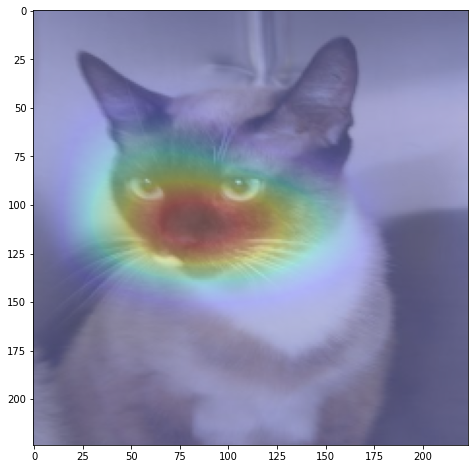

ground truth: dog
sigmoid output: [[1.526232e-15 1.000000e+00]]
prediction: dog


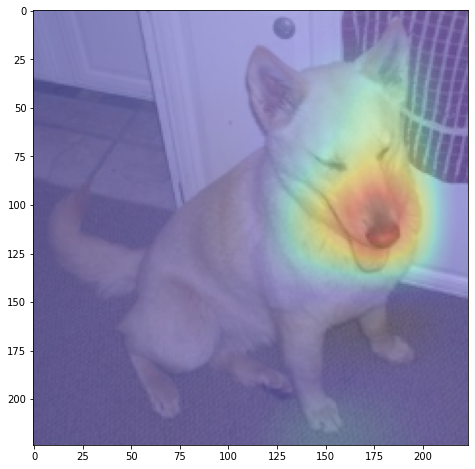

ground truth: dog
sigmoid output: [[2.5163184e-25 1.0000000e+00]]
prediction: dog


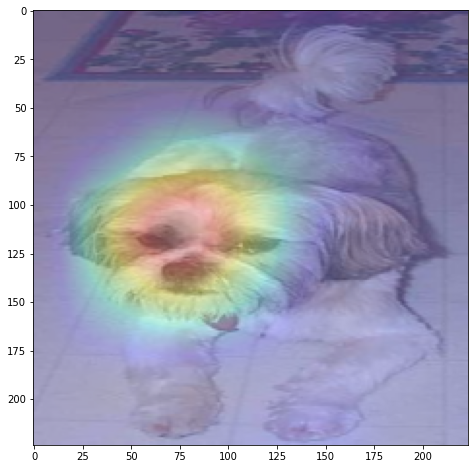

ground truth: cat
sigmoid output: [[1. 0.]]
prediction: cat


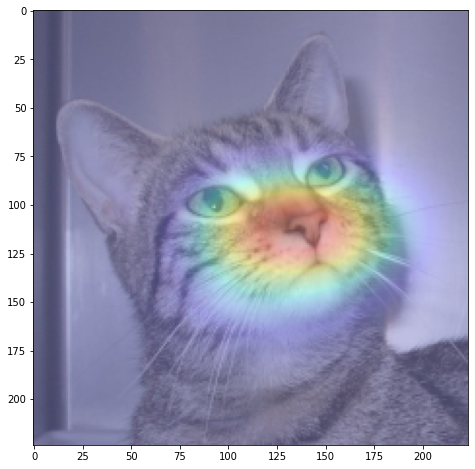

ground truth: cat
sigmoid output: [[1. 0.]]
prediction: cat


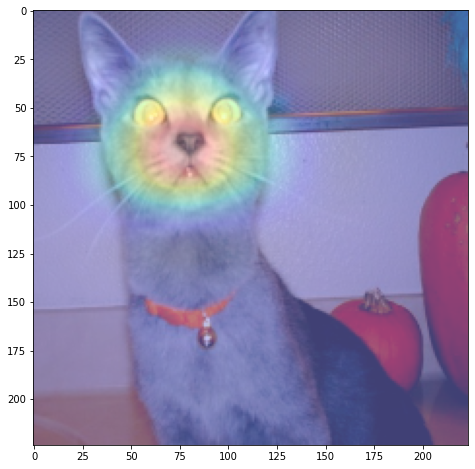

In [ ]:
EPOCHS = 10
model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, 
                                                 model.layers[-1].output))
cam_model.summary()

gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

def show_cam(image_value, features, results, label):
  '''
  Displays the class activation map of an image
  Args:
  image_value (tensor) -- preprocessed input image with size 224 x 224
  features (array) -- features of the image, shape (1, 7, 7, 512)
  results (array) -- output of the sigmoid layer
  '''
  features_for_img = features[0]
  prediction = results[0]
  class_activation_weigths = gap_weights[:,label]
  class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
  cam_output = np.dot(class_activation_features, class_activation_weigths)
  cam_output = tf.reshape(cam_output, (224,224))
  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if tf.argmax(results[0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

# preprocess the test images
augmented_test_data = test_examples.map(normalize_and_resize)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results, lbl)